In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("IMDB Dataset.csv")       # columns: review, sentiment
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Checking the format of the csv file.

Some statistical analysis about our dataset.

Review length (tokens):
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: len, dtype: float64


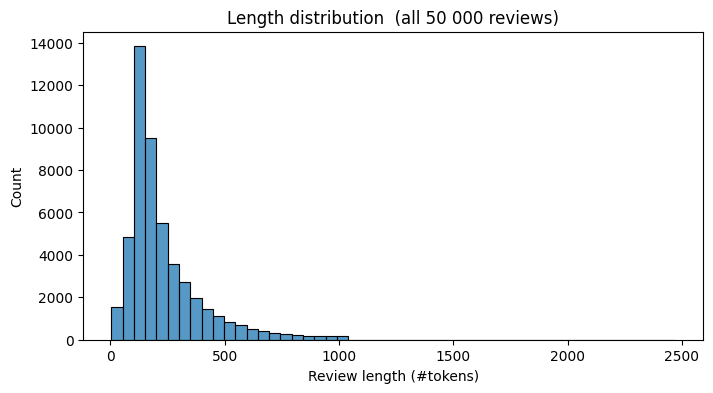

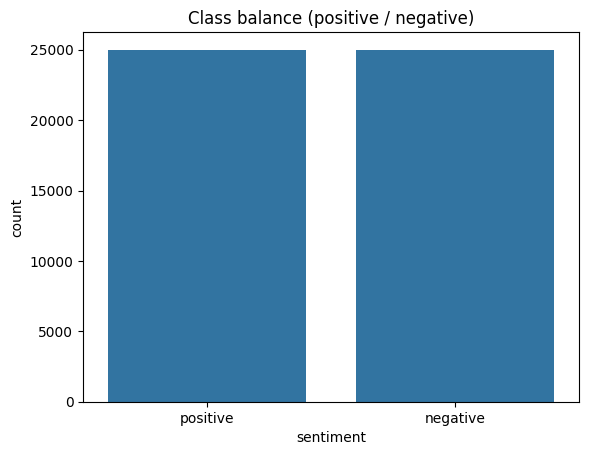

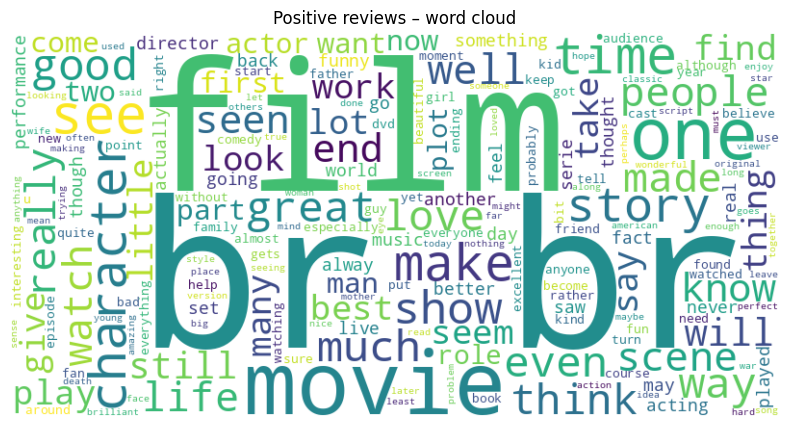

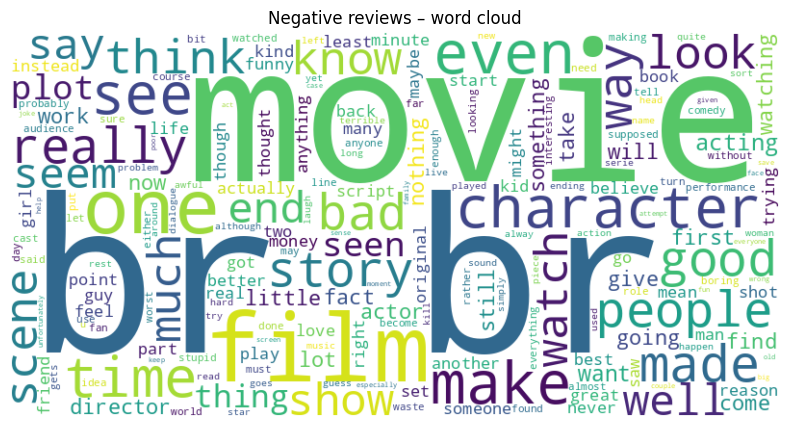

In [ ]:
# EDA: basic stats, plots, word-clouds
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

df["len"] = df.review.str.split().str.len()

print("Review length (tokens):")
print(df["len"].describe())

plt.figure(figsize=(8,4))
sns.histplot(df["len"], bins=50, kde=False)
plt.xlabel("Review length (#tokens)")
plt.title("Length distribution  (all 50 000 reviews)")
plt.show()


sns.countplot(x="sentiment", data=df)
plt.title("Class balance (positive / negative)")
plt.show()

for label, colour in [("positive", "Positive"), ("negative", "Negative")]:
    text = " ".join(df.loc[df.sentiment == label, "review"].str.lower().tolist())
    wc = WordCloud(width=800, height=400,
                   background_color="white",
                   stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear'); plt.axis("off")
    plt.title(f"{colour} reviews – word cloud")
    plt.show()



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
        df.review, df.sentiment.map({'negative':0,'positive':1}),
        test_size=0.2, random_state=42, stratify=df.sentiment)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50_000,
                        stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

Logistic Regression is a linear classifier, so we need a fixed-size numeric feature vector for every review.

-Lower-casing, strip HTML, remove punctuation.

-Tokenizing + stop word removal.

-Vectorizing with TFIDF n-grams.

With the code above, we fulfill these needs.

Used a test size of 0.2 (10000 samples)
Validation 0.08 (4000 samples)
Train 0.72 (36000 samples)

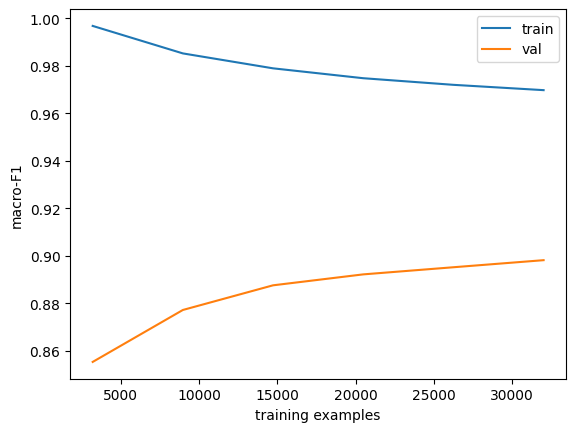

In [ ]:
from sklearn.model_selection import learning_curve
sizes, train_scores, val_scores = learning_curve(
        best_lr, X_train_vec, y_train,
        train_sizes=np.linspace(0.1, 1.0, 6),
        cv=5, scoring='f1_macro', n_jobs=-1)

import matplotlib.pyplot as plt
plt.plot(sizes, train_scores.mean(axis=1), label="train")
plt.plot(sizes, val_scores.mean(axis=1), label="val")
plt.xlabel("training examples"); plt.ylabel("macro-F1"); plt.legend();


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
param_grid = {'C':[0.01,0.1,1,3,10]}
gs = GridSearchCV(log_reg, param_grid,
                  scoring='f1_macro', cv=5, n_jobs=-1)
gs.fit(X_train_vec, y_train)

best_lr = gs.best_estimator_
print("Best C:", gs.best_params_['C'])


Best C: 3


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_pred = best_lr.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=['neg','pos']))
print("Macro-F1:", f1_score(y_test, y_pred, average='macro'))


              precision    recall  f1-score   support

         neg       0.91      0.90      0.91      5000
         pos       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Macro-F1: 0.9081946973257176


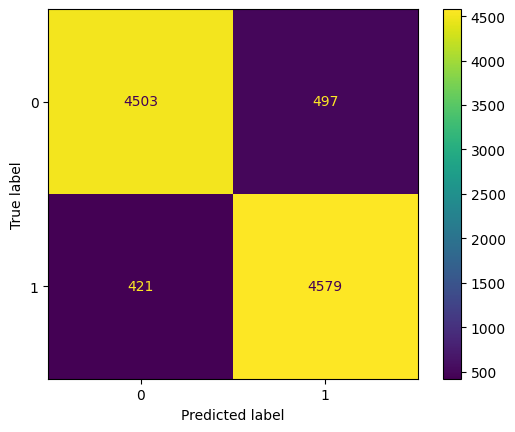

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [ ]:

# get predictions and probabilities
y_pred       = best_lr.predict(X_test_vec)
y_pred_prob  = best_lr.predict_proba(X_test_vec)[:, 1]   # P(positive)

# assemble a results table
results = pd.DataFrame({
    "review"      : X_test.reset_index(drop=True),
    "true_label"  : y_test.reset_index(drop=True).map({0:"negative", 1:"positive"}),
    "pred_label"  : pd.Series(y_pred).map({0:"negative", 1:"positive"}),
    "pred_prob"   : y_pred_prob
})

# keep only mis-classifications
miss = results[results.true_label != results.pred_label].copy()

# confidence = model’s probability for the label it actually predicted
miss["confidence"] = np.where(miss.pred_label == "positive",
                              miss.pred_prob,
                              1 - miss.pred_prob)

# show the N most confident errors
N = 20
pd.set_option("display.max_colwidth", None)
display(miss.sort_values("confidence", ascending=False).head(N))


,review,true_label,pred_label,pred_prob,confidence
2037,"This flick is sterling example of the state of erotic B-movies: bad porn movies without the hardcore sex. The plot in this one isn't so bad as these things go; it involves a female lawyer trying to prove her lover is innocent of killing his wife. The rest of the movie, however, leaves something to be desired. Bad acting, bad direction, bad looking woman, bad sets, bad cinematography, bad sound and bad sex scenes. The filmmakers should learn the difference between raunchy and erotic. They don't even have the common sense to have Gabriella Hall naked or in a love scene.<br /><br /> How dumb is that?",positive,negative,0.002254,0.997746
3157,"This sleek, sexy movie is a must-see. Only upon multiple viewings can one truly understand the uniqueness of this film. Personally I enjoy the narrator for his intelligent, no subject left untouched, style of narration. The introduction grips you right away, and holds you at the edge of your seat throughout the film. He provides wonderful insight into the world of the trainables and allows the audience to really 'connect' with internal horror this film exhibits. The script itself holds the movie together wonderfully. Not only for kids, but the elderly alike will gain a higher understanding of the trainables and the modern grasp that they have on the sexual experience. Ahead of its time and groundbreaking in cinematography, it surely defines the word 'masterpiece'.",negative,positive,0.989663,0.989663
606,"If you've ever wondered why they don't make porn with a plot, watch Dream Quest. On the one hand, you have to give the Armstrong credit both for making the effort to capitalize on this idea and for using such a strong adult cast to put some name power behind it. On the other hand, it also quickly becomes apparent why most porns never have more than 15 or 20 seconds of dialog connecting sex scenes together. These people simply cannot act (and the story is, unfortunately, lame to a ridiculous degree).<br /><br />Still, I gave it a 7 because it was a nice try and there didn't seem to be much of an effort to cut corners. Also, I'd like to see more attempts like this one. Maybe someday I will see the perfect combination of porn and plot.",positive,negative,0.011117,0.988883
9912,"Great movie - especially the music - Etta James - ""At Last"". This speaks volumes when you have finally found that special someone.",negative,positive,0.987283,0.987283
9982,"Okay, first of all I got this movie as a Christmas present so it was FREE! FIRST - This movie was meant to be in stereoscopic 3D. It is for the most part, but whenever the main character is in her car the movie falls flat to 2D! What!!?!?! It's not that hard to film in a car!!! SECOND - The story isn't very good. There are a lot of things wrong with it.<br /><br />THIRD - Why are they showing all of the deaths in the beginning of the film! It made the movie suck whenever some was going to get killed!!! Watch it for a good laugh , but don't waste your time buying it. Just download it or something for cheap.",positive,negative,0.014517,0.985483
3069,"This movie has to be my favorite of all time. Its not supposed to have a plot, because its makers wanted people (Charlie Sheen, I think)to believe it was a real snuff film. This was an exercise in visual effects, and doesn't cut away when the action happens like every other film does. Movies these days are now all about sound effects, leaving the visuals to be made by computers cause its easier to deal with CGI blood. There still are movie makers who still can't get fake blood to look like the real thing. There is no rape scene because that wasn't the point of making the film. Have you seen the hills have eyes 2? The rape scene was funny instead of shocking. Although i'm sure there are some GONZO porn film makers that have tried to marry porn with horror. But since they probably suck at making films, they probably wouldn't be able to pull it off. 